# Library & Packages

In [ ]:
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy import stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# for preprocessing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# !pip install transformers
# from transformers import BertTokenizer, BertModel
# from transformers import AdamW, get_linear_schedule_with_warmup


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Exploratory Data Analysis

In [ ]:
df = pd.read_csv("twitter_review_data.csv", encoding='utf-8')
df.head()

,Sl no,Tweets,Search key,Feeling
0,1,"#1: @fe ed ""RT @MirayaDizon1: Time is ticking...",happy moments,happy
1,2,"#2: @蓮花 &はすか ed ""RT @ninjaryugo: ＃コナモンの日 だそうで...",happy moments,happy
2,3,"#3: @Ris ♡ ed ""Happy birthday to one smokin h...",happy moments,happy
3,4,"#4: @월월 [씍쯴사랑로봇] jwinnie is the best, cheer u...",happy moments,happy
4,5,"#5: @Madhurima wth u vc♥ ed ""Good morning dea...",happy moments,happy


In [ ]:
len(df)

10017

In [ ]:
df['Feeling'].unique()

array(['happy', 'sad', 'angry', 'fear', 'disgust', 'surprise'],
      dtype=object)

### Missing Values (N/A Values)

In [ ]:
df.isna().sum()

Sl no         0
Tweets        0
Search key    0
Feeling       0
dtype: int64

### Data Distribution

As we can see, the data distribution is right-skewed. So, it's pretty **imbalance**. Skewed data does not work well with many statistical methods. However, *tree based models* are not affected.
* Since it's right-skewed, the model will predict better on data points with lower value compared to those with higher values

To remedy this situation, there are several techniques:
* Log transformation: remove skewness from the predictor
* Square transformation: makes the range smaller
    - Sometimes works great and sometimes isn’t the best suitable option
* Box-Cox transformation: your data must be **positive**

However, these techniques will only work with numbers data type.

NOTE: we have to reverse the transformation once when making predictions, so keep that in mind.

Text(0, 0.5, 'Number of Tweets')

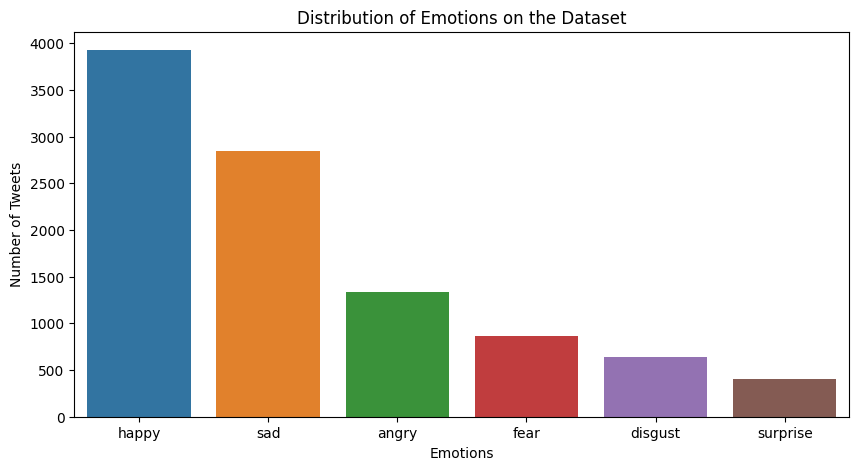

In [ ]:
list_classes = ["happy", "sad", "angry", "fear", "disgust", "surprise"]
plt.figure(figsize = (10,5))
sns.countplot(df, x="Feeling")
plt.title("Distribution of Emotions on the Dataset")
plt.xlabel("Emotions")
plt.ylabel("Number of Tweets")

# # checking for skewness -> only works will numbers too
# df['Feeling'].skew()

In [ ]:
# to get the exact number
df.Feeling.value_counts()

happy       3928
sad         2849
angry       1341
fear         863
disgust      637
surprise     399
Name: Feeling, dtype: int64

### Data Length for Each Emotions

<Figure size 500x500 with 0 Axes>

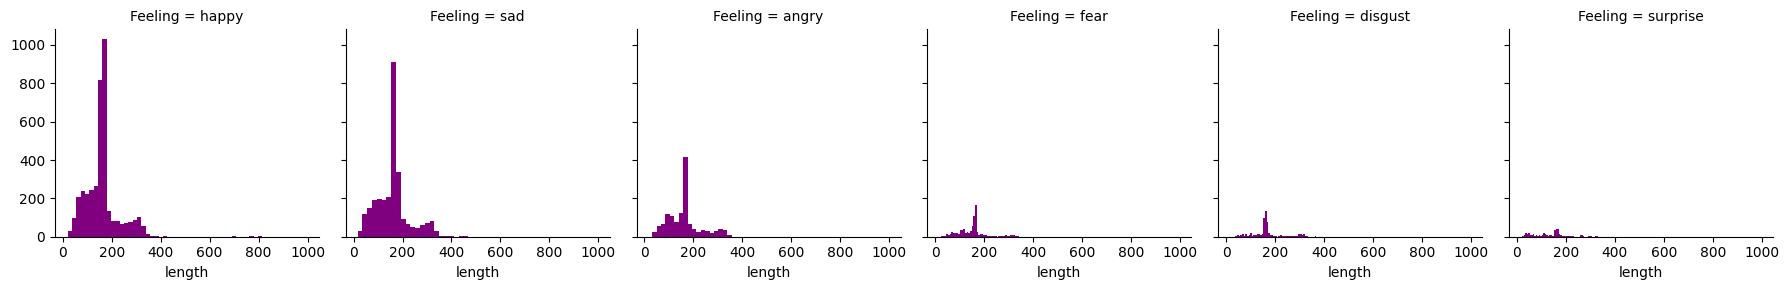

In [ ]:
df.describe(include='all')
df['length'] = df['Tweets'].apply(len)
df.head()
plt.figure(figsize = (5,5))
graph = sns.FacetGrid(data=df,col='Feeling')
graph.map(plt.hist,'length',bins=50,color='Purple')

# Data Preprocessing

As we can see from the data, the comments/tweets have emojis and unnecessary characters in it. We can improve them by stemming and lemmatizing the comments so that it's clearer and help the model to understand better regarding the context of the tweet

In [ ]:
emoji_pattern = re.compile("["
                           u"U0001F600-U0001F64F"  # emoticons
                           u"U0001F300-U0001F5FF"  # symbols & pictographs
                           u"U0001F680-U0001F6FF"  # transport & map symbols
                           u"U0001F1E0-U0001F1FF"  # flags (iOS)
                           u"U00002702-U000027B0"
                           u"U000024C2-U0001F251"
                           "]+", flags=re.UNICODE)


def preprocess(text):
    text = text.strip()  # stripping unnecessary whitespaces at the beginning and the end
    text = re.sub('@[^\w]+', '', text)  # remove username
    text = re.sub(r'\[[0-9]*\]', ' ', text)  # replace number and parentheses with whitespace
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    # lowercase all of our alphabets/numbers and don't include any characters, such as *, ', =, etc.
    # ^ = negation so don't include these
    text = re.sub(r'\d', ' ', text) # replace digits with whitepace
    text = re.sub(r'\s+', ' ', text) # replace ≥ 1 whitespaces with just 1 whitespace
    text = re.sub(r'(!|.)1+', '', text) # replace punctuations
    text = emoji_pattern.sub(r'', text) # remove emojis
    return text


### Remove Stopword

We are removing words that hold little meaning, such as "a", "the", "is", "are", "and", "or", etc.

In [ ]:
def remove_stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

### Lemmatization

In [ ]:
# initialize the lemmatizer
WNlemmatizer = WordNetLemmatizer()

# a helper function to map nltk grammar position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# tokenize the sentence
def lemmatizer(string):
    # pos_tag attaches a tag to every word indicating what grammar position it is (e.g. is it a verb, noun, etc.)
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # get the grammar position tags
    a = [WNlemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(remove_stopword(preprocess(string)))

### Final Preprocessing

In [ ]:
df['refined_tweet'] = df['Tweets'].apply(finalpreprocess)

### Tokenizer

#### TF-IDF

In [ ]:
tfidf = TfidfVectorizer()
tf_idf_text = tfidf.fit_transform(df['refined_tweet'])

In [ ]:
# df.replace(["happy", "sad", "angry", "fear", "disgust",
#            "surprise"], [0, 1, 2, 3, 4, 5], inplace=True)

tokenized_tweets = tf_idf_text
truth_feeling = df['Feeling']

# Split into training and test set
tweet_train, tweet_test, y_train, y_test = train_test_split(
    tokenized_tweets, truth_feeling, test_size=0.2, random_state=1)


# Models

## Baselines ML Models

#### K-Nearest Neighbours (KNN)

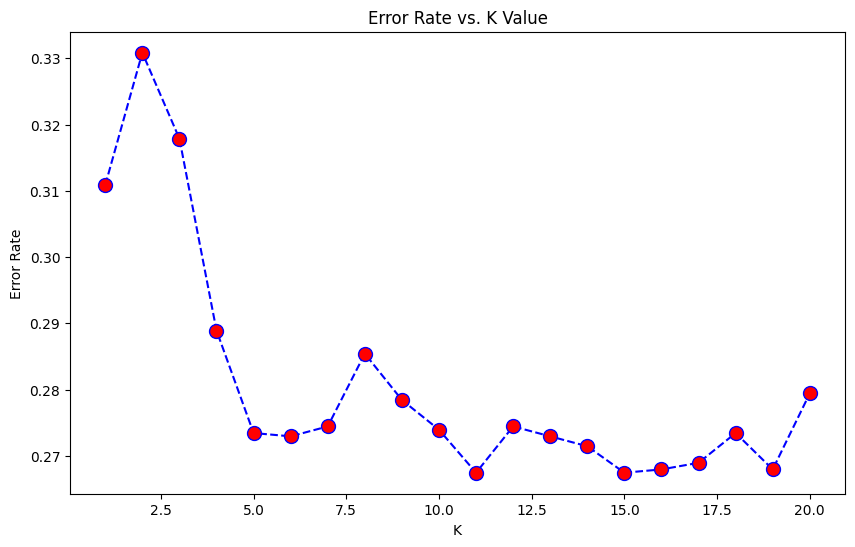

Lowest Error Rate: 0.26746506986027946
K-value of the Lowest Error Rate: 11


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

###############
# PICK THE BEST K (ELBOW METHOD)
###############

error_rate = []
MAX_K = 20
lowest_error = 1.0
best_elbow_k = 1
for i in range(1, MAX_K+1):

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(tweet_train, y_train)
    pred_i = knn.predict(tweet_test)
    error_val = np.mean(pred_i != y_test)
    error_rate.append(error_val)
    if error_val < lowest_error:
      lowest_error = error_val
      best_elbow_k = i

plt.figure(figsize=(10, 6))
plt.plot(range(1, MAX_K+1), error_rate, color='blue',
         linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)

plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

print("Lowest Error Rate:", lowest_error)
print("K-value of the Lowest Error Rate:", best_elbow_k)

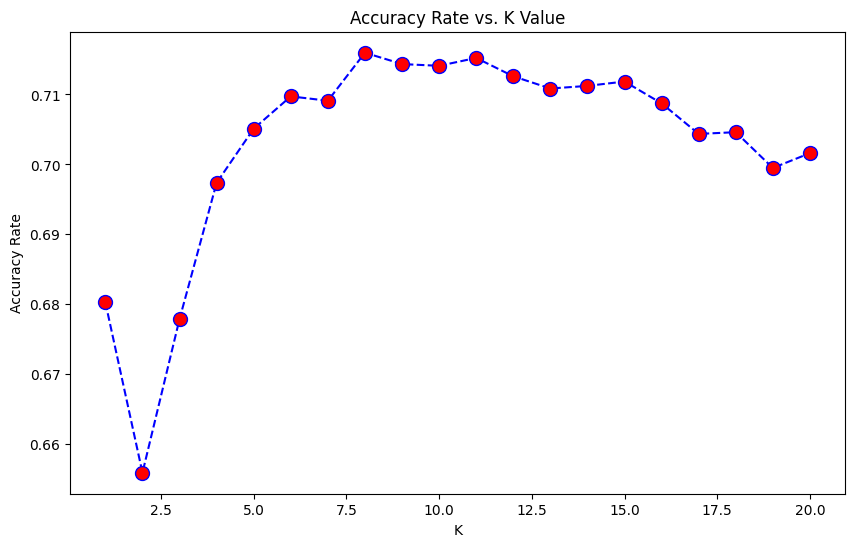

Highest Accuracy Rate: 0.7159594642691645
K-value of the Highest Accuracy Rate: 8


In [ ]:
###############
# PICK THE BEST K (CROSS VALIDATION METHOD)
###############

accuracy_rate = []
best_cv_k = 1
highest_accuracy = 0
for i in range(1, MAX_K+1):

    knn = KNeighborsClassifier(n_neighbors=i)
    score = cross_val_score(knn, tweet_train, y_train, cv=5)
    accuracy_rate.append(np.mean(score))
    if highest_accuracy < np.mean(score):
      highest_accuracy = np.mean(score)
      best_cv_k = i

plt.figure(figsize=(10, 6))
plt.plot(range(1, MAX_K+1), accuracy_rate, color='blue',
         linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)

plt.title('Accuracy Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy Rate')
plt.show()

print("Highest Accuracy Rate:", highest_accuracy)
print("K-value of the Highest Accuracy Rate:", best_cv_k)

In [ ]:
###############
# TRAIN THE KNN
###############


knn_elbow = KNeighborsClassifier(n_neighbors=best_elbow_k, algorithm="auto")
knn_CV = KNeighborsClassifier(n_neighbors=best_cv_k, algorithm="auto")

knn_elbow.fit(tweet_train, y_train)
knn_CV.fit(tweet_train, y_train)

KNeighborsClassifier(n_neighbors=8)

### Random Forest
* Hyperparamters to increase performance:
  * `n_estimators`: Number of trees the algorithm builds before averaging the predictions.
  * `max_features`: Maximum number of features random forest considers splitting a node.
  * `mini_sample_leaf`: Determines the minimum number of leaves required to split an internal node.
  * `criterion`: How to split the node in each tree? (Entropy/Gini impurity/Log Loss)
  * `max_leaf_nodes`: Maximum leaf nodes in each tree
* Hyperparameters to increase speed:
  * `n_jobs`: tells how many processors it is allowed to use
    * If it's 1, can only use 1 processor
    * If it's -1, there's no limit
  * `random_state`: controls randomness of the sample.
    * If it has a definite value of random state -> the model will always produce the same results
  * `oob`: out of the bag
    * It's a random forest *cross-validation* method
    * Out-of-bag samples: 1/3 of the sample is used to evaluate its performance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

###############
# WITHOUT HYPERPARAMETERS TUNING
###############
random_forest_ori = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

random_forest_ori.fit(tweet_train, y_train)
random_forest_ori.oob_score_


0.4102084113315862

In [ ]:
###############
# WITH HYPERPARAMETERS TUNING (GridSearchCV)
###############

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

random_forest_tuned = RandomForestClassifier(random_state=42, n_jobs=-1)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = random_forest_tuned,
                           param_grid = params,
                           cv = 4, # cross validation fold
                           n_jobs = -1,
                           verbose = 1,
                           scoring = "accuracy")

grid_search.fit(tweet_train, y_train)
grid_search.best_score_
best_rf_tuned = grid_search.best_estimator_

Fitting 4 folds for each of 180 candidates, totalling 720 fits


In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 25}


### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

###############
# WITHOUT HYPERPARAMETERS TUNING
###############

svm = SVC(random_state=42)

svm.fit(tweet_train, y_train)

SVC(random_state=42)

In [ ]:
###############
# WITH HYPERPARAMETERS TUNING (GridSearchCV)
###############

params = {
    'C':[0.01,0.1,1,10],
    'kernel' : ["linear","rbf","sigmoid"], # can do poly
    'degree' : [1,3,5,7],
    'gamma' : [0.01,1] # kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
}

svm  = SVC(random_state=42)
svm_cv = GridSearchCV(estimator = svm,
                      param_grid = params,
                      cv = 4,
                      verbose = 1)
svm_cv.fit(tweet_train,y_train)
print("Best Parameters:", svm_cv.best_params_)

best_svm = svm_cv.best_estimator_

Fitting 4 folds for each of 96 candidates, totalling 384 fits
Best Parameters: {'C': 10, 'degree': 1, 'gamma': 1, 'kernel': 'sigmoid'}


### Evaluation

##################
KNN Using Elbow Method
##################
Confusion Matrix


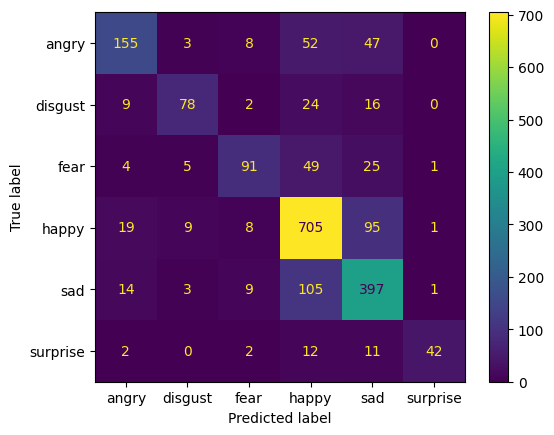


Classfication Report
              precision    recall  f1-score   support

       angry       0.76      0.58      0.66       265
     disgust       0.80      0.60      0.69       129
        fear       0.76      0.52      0.62       175
       happy       0.74      0.84      0.79       837
         sad       0.67      0.75      0.71       529
    surprise       0.93      0.61      0.74        69

    accuracy                           0.73      2004
   macro avg       0.78      0.65      0.70      2004
weighted avg       0.74      0.73      0.73      2004


Accuracy Score: 0.7325349301397206
Precision Score: 0.7325349301397206
Recall Score: 0.7325349301397206
F1 Score: 0.7325349301397206



##################
KNN Using 5-fold Cross Validation
##################
Confusion Matrix


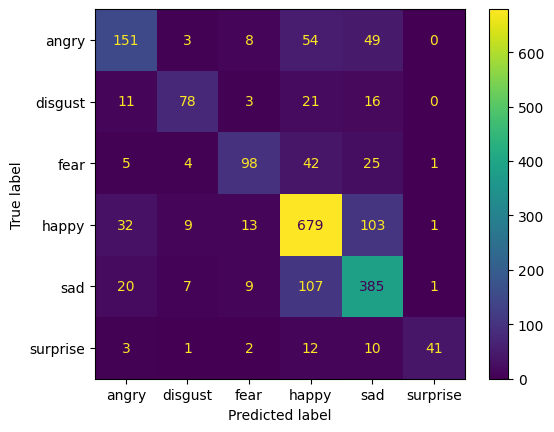


Classfication Report
              precision    recall  f1-score   support

       angry       0.68      0.57      0.62       265
     disgust       0.76      0.60      0.68       129
        fear       0.74      0.56      0.64       175
       happy       0.74      0.81      0.78       837
         sad       0.65      0.73      0.69       529
    surprise       0.93      0.59      0.73        69

    accuracy                           0.71      2004
   macro avg       0.75      0.64      0.69      2004
weighted avg       0.72      0.71      0.71      2004


Accuracy Score: 0.7145708582834331
Precision Score: 0.7145708582834331
Recall Score: 0.7145708582834331
F1 Score: 0.7145708582834331


In [ ]:
print("##################")
print("KNN Using Elbow Method")
print("##################")
knn_elbow_y_pred = knn_elbow.predict(tweet_test)
print("Confusion Matrix")
knn_elbow_cm = confusion_matrix(y_test, knn_elbow_y_pred)
knn_elbow_disp = ConfusionMatrixDisplay(confusion_matrix = knn_elbow_cm, display_labels = knn_elbow.classes_)
knn_elbow_disp.plot()
plt.show()
print("")
print("Classfication Report")
print(classification_report(y_test, knn_elbow_y_pred))
print("")
print("Accuracy Score:", accuracy_score(y_test, knn_elbow_y_pred))
print("Precision Score:", precision_score(y_test, knn_elbow_y_pred, average='micro'))
print("Recall Score:", recall_score(y_test, knn_elbow_y_pred, average='micro'))
print("F1 Score:", f1_score(y_test, knn_elbow_y_pred, average='micro'))
print("\n\n")

print("##################")
print("KNN Using 5-fold Cross Validation")
print("##################")
knn_cv_y_pred = knn_CV.predict(tweet_test)
print("Confusion Matrix")
knn_cv_cm = confusion_matrix(y_test, knn_cv_y_pred)
knn_cv_disp = ConfusionMatrixDisplay(confusion_matrix = knn_cv_cm, display_labels = knn_CV.classes_)
knn_cv_disp.plot()
plt.show()
print("")
print("Classfication Report")
print(classification_report(y_test, knn_cv_y_pred))
print("")
print("Accuracy Score:", accuracy_score(y_test, knn_cv_y_pred))
print("Precision Score:", precision_score(y_test, knn_cv_y_pred, average='micro'))
print("Recall Score:", recall_score(y_test, knn_cv_y_pred, average='micro'))
print("F1 Score:", f1_score(y_test, knn_cv_y_pred, average='micro'))

##################
Random Forest Without Hyperparameter Tuning
##################
Confusion Matrix


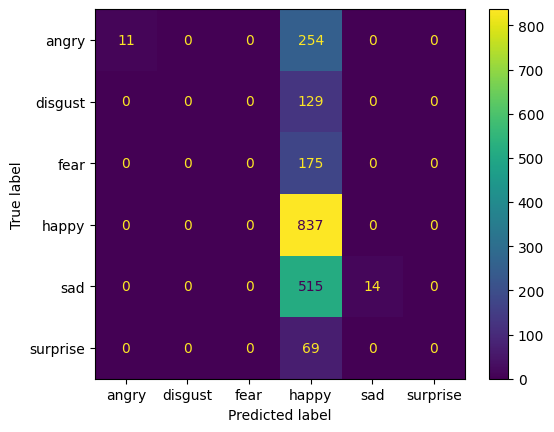


Classfication Report
              precision    recall  f1-score   support

       angry       1.00      0.04      0.08       265
     disgust       0.00      0.00      0.00       129
        fear       0.00      0.00      0.00       175
       happy       0.42      1.00      0.59       837
         sad       1.00      0.03      0.05       529
    surprise       0.00      0.00      0.00        69

    accuracy                           0.43      2004
   macro avg       0.40      0.18      0.12      2004
weighted avg       0.57      0.43      0.27      2004


Accuracy Score: 0.4301397205588822
Precision Score: 0.4301397205588822
Recall Score:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 0.4301397205588822
F1 Score: 0.4301397205588822



##################
Random Forest With GridSearchCV
##################
Confusion Matrix


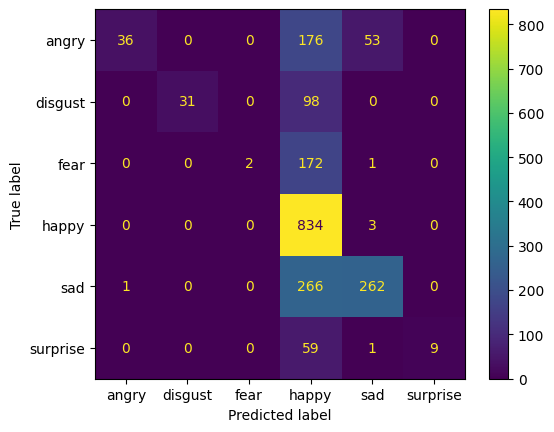


Classfication Report
              precision    recall  f1-score   support

       angry       0.97      0.14      0.24       265
     disgust       1.00      0.24      0.39       129
        fear       1.00      0.01      0.02       175
       happy       0.52      1.00      0.68       837
         sad       0.82      0.50      0.62       529
    surprise       1.00      0.13      0.23        69

    accuracy                           0.59      2004
   macro avg       0.89      0.33      0.36      2004
weighted avg       0.75      0.59      0.51      2004


Accuracy Score: 0.5858283433133733
Precision Score: 0.5858283433133733
Recall Score: 0.5858283433133733
F1 Score: 0.5858283433133733


In [ ]:
print("##################")
print("Random Forest Without Hyperparameter Tuning")
print("##################")
rf_ori_pred = random_forest_ori.predict(tweet_test)
print("Confusion Matrix")
rf_ori_cm = confusion_matrix(y_test, rf_ori_pred)
rf_ori_disp = ConfusionMatrixDisplay(confusion_matrix = rf_ori_cm, display_labels = random_forest_ori.classes_)
rf_ori_disp.plot()
plt.show()
print("")
print("Classfication Report")
print(classification_report(y_test, rf_ori_pred))
print("")
print("Accuracy Score:", accuracy_score(y_test, rf_ori_pred))
print("Precision Score:", precision_score(y_test, rf_ori_pred, average='micro')) #in multiclass classification, we need to add average
print("Recall Score:", recall_score(y_test, rf_ori_pred, average='micro'))
print("F1 Score:", f1_score(y_test, rf_ori_pred, average='micro'))
print("\n\n")

print("##################")
print("Random Forest With GridSearchCV")
print("##################")
rf_tuned = best_rf_tuned.predict(tweet_test)
print("Confusion Matrix")
rf_tuned_cm = confusion_matrix(y_test, rf_tuned)
rf_tuned_disp = ConfusionMatrixDisplay(confusion_matrix = rf_tuned_cm, display_labels = best_rf_tuned.classes_)
rf_tuned_disp.plot()
plt.show()
print("")
print("Classfication Report")
print(classification_report(y_test, rf_tuned))
print("")
print("Accuracy Score:", accuracy_score(y_test, rf_tuned))
print("Precision Score:", precision_score(y_test, rf_tuned, average='micro'))
print("Recall Score:", recall_score(y_test, rf_tuned, average='micro'))
print("F1 Score:", f1_score(y_test, rf_tuned, average='micro'))

##################
SVM Without Hyperparameter Tuning
##################
Confusion Matrix


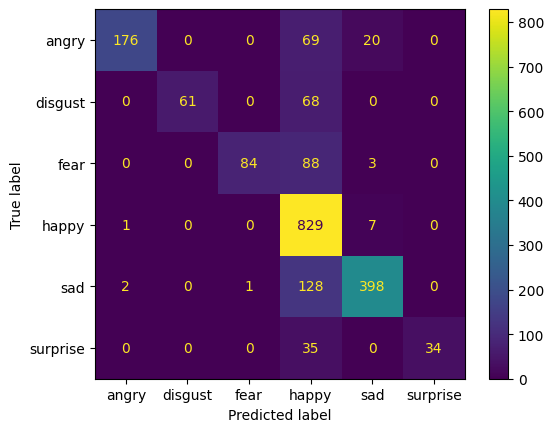


Classfication Report
              precision    recall  f1-score   support

       angry       0.98      0.66      0.79       265
     disgust       1.00      0.47      0.64       129
        fear       0.99      0.48      0.65       175
       happy       0.68      0.99      0.81       837
         sad       0.93      0.75      0.83       529
    surprise       1.00      0.49      0.66        69

    accuracy                           0.79      2004
   macro avg       0.93      0.64      0.73      2004
weighted avg       0.85      0.79      0.78      2004


Accuracy Score: 0.7894211576846307
Precision Score: 0.7894211576846307
Recall Score: 0.7894211576846307
F1 Score: 0.7894211576846307



##################
SVM With GridSearchCV
##################
Confusion Matrix


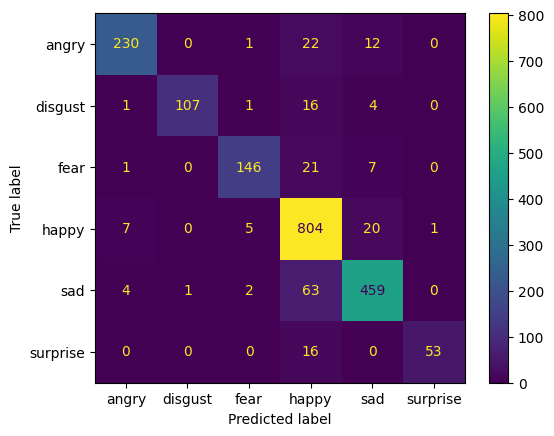


Classfication Report
              precision    recall  f1-score   support

       angry       0.95      0.87      0.91       265
     disgust       0.99      0.83      0.90       129
        fear       0.94      0.83      0.88       175
       happy       0.85      0.96      0.90       837
         sad       0.91      0.87      0.89       529
    surprise       0.98      0.77      0.86        69

    accuracy                           0.90      2004
   macro avg       0.94      0.85      0.89      2004
weighted avg       0.90      0.90      0.90      2004


Accuracy Score: 0.8977045908183633
Precision Score: 0.8977045908183633
Recall Score: 0.8977045908183633
F1 Score: 0.8977045908183633


In [ ]:
print("##################")
print("SVM Without Hyperparameter Tuning")
print("##################")
svm_ori = svm.predict(tweet_test)
print("Confusion Matrix")
svm_ori_cm = confusion_matrix(y_test, svm_ori)
svm_ori_disp = ConfusionMatrixDisplay(confusion_matrix = svm_ori_cm, display_labels = svm.classes_)
svm_ori_disp.plot()
plt.show()
print("")
print("Classfication Report")
print(classification_report(y_test, svm_ori))
print("")
print("Accuracy Score:", accuracy_score(y_test, svm_ori))
print("Precision Score:", precision_score(y_test, svm_ori, average='micro')) #in multiclass classification, we need to add average
print("Recall Score:", recall_score(y_test, svm_ori, average='micro'))
print("F1 Score:", f1_score(y_test, svm_ori, average='micro'))
print("\n\n")

print("##################")
print("SVM With GridSearchCV")
print("##################")
svm_tuned = best_svm.predict(tweet_test)
print("Confusion Matrix")
svm_tuned_cm = confusion_matrix(y_test, svm_tuned)
svm_tuned_disp = ConfusionMatrixDisplay(confusion_matrix = svm_tuned_cm, display_labels = best_svm.classes_)
svm_tuned_disp.plot()
plt.show()
print("")
print("Classfication Report")
print(classification_report(y_test, svm_tuned))
print("")
print("Accuracy Score:", accuracy_score(y_test, svm_tuned))
print("Precision Score:", precision_score(y_test, svm_tuned, average='micro'))
print("Recall Score:", recall_score(y_test, svm_tuned, average='micro'))
print("F1 Score:", f1_score(y_test, svm_tuned, average='micro'))

## Deep Learning Models

In [ ]:
class TwitterDataset(torch.utils.data.Dataset):

    def __init__(self, tweet, label, transform = None):

        self.len = len(label)
        self.tweet = tweet
        self.label = label

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        image = self.tweet[idx]
        label = self.label[idx]

        return {'tweet': torch.tensor(image, dtype = torch.long), 'label': torch.tensor(label, dtype = torch.long)}

In [ ]:
train_dataset = TwitterDataset(tweet_train, y_train)
test_dataset = TwitterDataset(tweet_test, y_test)

### Uni-LSTM

* There are 3 ways to initialize the hidden state
  * *Zero Initialization*: Initialize all the hidden state to 0
    * Cons: If training set contains short sentences, then it is prone to overfitting since the model becomes increasingly tuned to zero state as the ratio of state resets to total samples increase
  * *Random Initialization*: Initialize the hidden state randomly.
    * Additional noise introduced by random initialization makes the model less sensitive to the initialization and thus less likely to overfit.
  * *Learn a default initial hidden state*: If we have many samples requiring a state reset for each of them, such as in a sentiment analysis/sequence classification problem, it makes sense to learn a default initial state.
    * Cons: if there are only a few long sequences with a handful of state resets, then it is prone to overfitting.
* Why should we initialize the hidden state every time we feed in a new batch, instead of once and for all?
  * Since each of our sample is an independent piece of text data, i.e. we have a lot of "state resets", there's no benefit in memorizing the hidden state from one batch and pass it onto another.
  * If our samples were all part of a long sequence, then memorizing the last hidden state will likely be informative for the next training batch.
  * If we want the hidden state to carry to the next batch, use `.detach()`

In [ ]:
class UniLSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, batch_size=2):
    super(UniLSTM, self).__init__()
    # hidden dim is also called "number of lstm units"
    # Whenever padding_idx = 0, embedding = 0.

    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
    # batch_first makes the input and output tensors become (batch, seq, feature) instead of (seq, batch, feature)

    self.fc = nn.Linear()
    self.dropout = nn.Dropout()

  def init_hidden(self):
        '''
        Initiate hidden states.
        '''
        # Shape for hidden state and cell state: num_layers * num_directions, batch, hidden_size
        # We randomly initialize the hidden state
        h_0 = torch.randn(1, self.batch_size, self.hidden_dim)
        c_0 = torch.randn(1, self.batch_size, self.hidden_dim)

        # The Variable API is now semi-deprecated, so we use nn.Parameter instead.
        # Note: For Variable API requires_grad=False by default;
        # For Parameter API requires_grad=True by default.
        h_0 = nn.Parameter(h_0, requires_grad=True)
        c_0 = nn.Parameter(c_0, requires_grad=True)

        return (h_0, c_0)

  def forward(self, x):



### Bi-LSTM

In [ ]:
class BiLSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, batch_size=2):
    super(UniLSTM, self).__init__()
    # hidden dim is also called "number of lstm units"
    # Whenever padding_idx = 0, embedding = 0.

    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
    # batch_first makes the input and output tensors become (batch, seq, feature) instead of (seq, batch, feature)

    self.fc = nn.Linear()
    self.dropout = nn.Dropout()

  def init_hidden(self):
        '''
        Initiate hidden states.
        '''
        # Shape for hidden state and cell state: num_layers * num_directions, batch, hidden_size
        # We randomly initialize the hidden state
        h_0 = torch.randn(1, self.batch_size, self.hidden_dim)
        c_0 = torch.randn(1, self.batch_size, self.hidden_dim)

        # The Variable API is now semi-deprecated, so we use nn.Parameter instead.
        # Note: For Variable API requires_grad=False by default;
        # For Parameter API requires_grad=True by default.
        h_0 = nn.Parameter(h_0, requires_grad=True)
        c_0 = nn.Parameter(c_0, requires_grad=True)

        return (h_0, c_0)

  def forward(self, x):

